Use the environment found on GCP at `conda activate /home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env`

In [22]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
from sklearn.model_selection import train_test_split
import random

# import from scfair-reproducibility
from scfair_reproducibility.benchmark_VAE.vi import VI
from scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker

# other methods
# import cpa
# from data.biolord_dev.src import biolord

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
#os.environ["CUDA_VISIBLE_DEVICES"]=""

In [24]:
from dis2pm.dis2pmvae import *
from dis2pm.dis2pmvi import *
from dis2pm.ood_m import *
from dis2pm.trainingplan_m import *
from dis2pm.utils_m import *

# prepare data: Heart Atlas

Define function to convert covariate names to numerical values

In [25]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

Load and subsample the heart atlas dataset from Litvinukova et al. Nature 2020

In [26]:
adata = scvi.data.heart_cell_atlas_subsampled()

# preprocess dataset
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

print(adata)
print(adata[:,1198].X)
adata_atac = adata[:, -200:].copy()
adata_rna = adata[:, :1000].copy()
adata_obs = adata.obs.copy()
adata_uns = adata.uns.copy()
adata_atac.X.data = np.ones(adata_atac.X.data.shape)
adata = ad.concat([adata_rna, adata_atac], axis=1)
adata.obs = adata_obs
adata.uns = adata_uns
print(adata[:,:].X.sum(axis=0))
print(adata)

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    layers: 'counts'
  (0, 0)	4.5277414
  (3, 0)	4.0320454
  (4, 0)	4.196429
  (7, 0)	2.1310735
  (9, 0)	1.2068739
  (11, 0)	2.9385843
  (14, 0)	3.3909585
  (15, 0)	4.0477786
  (16, 0)	5.345359
  (18, 0)	1.5867883
  (20, 0)	1.2203416
  (21, 0)	4.835906
  (24, 0)	2.8654125
  (25, 0)	2.3536403
  (28, 0)	2.6903114
  (32, 0)	1.9224532
  (35, 0)	2.4982107
  (36,

/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):
/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


[[5590.68177193 1019.82674909 1078.93260568 ... 7484.
  7558.         8864.        ]]
AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    layers: 'counts'


/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [27]:
# df = adata.to_df()
# print(df)
# df_subset = df.iloc[:, -200:]
# print(df_subset)
# print(df_subset[df_subset.ge(2).any(axis=1)])



# train model: dis2p(n_cf=1)

In [28]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
# train params
epochs = 400
batch_size = 128 #128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2pm'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
# try:
#     model = Dis2pmVI.load(f"{pre_path}/{model_name}", adata=adata)

# # trains the model (if not trained before) and save it into: pre_path + model_name
# except:

Dis2pmVI.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
print(adata)
model = Dis2pmVI(adata, n_genes=1000, n_regions=200, n_layers=n_layers)
model.train( **train_dict, )
model.save(f"{pre_path}/{model_name}")

[autoreload of dis2pm.dis2pmvae failed: Traceback (most recent call last):
  File "/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/jupyter/analysis/dis2p_trials/scfair_20231003/scfair_dev_20231003_env/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'cell_type_idx', 'cell_source_idx', 'gender_idx', 'region_idx', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs'
    layers: 'counts'
1000
debug4
n_cats_per_cov is (11, 4, 2, 6)
debug4
debug5
200
Epoch 5/400:   1%|          | 4/400 [01:17<2:07:31, 19.32s/it, v_num=1, loss_validation=1.85e+3, x_0_val

In [ ]:
# debug the decoder part

from scvi.module._peakvae import Decoder as DecoderPeakVI

n_latent_shared = 10
n_input_regions = 200
n_layers= 1 
n_hidden=128 
deeply_inject_covariates=True,
use_batch_norm=True,
use_layer_norm=False,
n_cats_per_cov = (11, 4, 2, 6)

x_decoder_acc =  DecoderPeakVI(
                    n_latent_shared,
                    n_input_regions,
                    n_cat_list=n_cats_per_cov,
                    n_layers=n_layers,
                    n_hidden=n_hidden,
                    deep_inject_covariates=deeply_inject_covariates,
                    use_batch_norm=use_batch_norm,
                    use_layer_norm=use_layer_norm,
                )

x_decoder_input_acc = torch.tensor([[-4.4676e-01, -3.9786e+00, -2.7232e-01, -3.6789e-01, -7.7361e-01,
          2.0212e+00,  4.1852e-01,  4.1563e-01, -1.2369e+00, -3.7879e-02],
        [-7.7658e-01,  6.8369e-01, -4.2950e-01,  7.7211e-01, -6.5420e-01,
          4.5324e-01,  7.3278e-01,  1.1801e+00, -6.4092e-01, -9.2426e-01],
        [ 1.3919e+00,  4.9893e-01,  9.8369e-01, -3.1391e-01, -2.4904e+00,
          2.9071e-01, -2.1565e+00,  1.0754e+00,  1.3819e+00,  9.1169e-01],
        [-3.2353e-01,  2.0121e+00,  7.2392e-02,  6.1906e-01,  1.9788e+00,
         -1.0337e+00, -6.6992e-02, -2.2644e+00, -8.4307e-01, -1.7462e-01],
        [-1.2778e-03,  1.1938e+00, -1.0378e+00, -1.6927e+00, -1.2386e+00,
         -1.9468e-02, -1.6706e+00, -1.6044e+00,  1.1005e+00,  1.4007e+00]]) #,device='cuda:0', grad_fn=<AddBackward0>)

library_acc = torch.tensor([[825.],
        [265.],
        [ 63.],
        [ 93.],
        [ 36.]]) #, device='cuda:0')

dec_covs = (
            torch.tensor([[ 2.],
        [ 3.],
        [10.],
        [ 8.],
        [ 8.]]), 
            torch.tensor([[1.],
        [0.],
        [0.],
        [0.],
        [3.]]), 
            torch.tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.]],), 
            torch.tensor([[4.],
        [1.],
        [2.],
        [2.],
        [4.]])
    
           )






px_acc = x_decoder_acc(
    x_decoder_input_acc,
    #library_acc,
    *dec_covs
)

print(px_acc)

In [7]:
x = torch.tensor([[ 0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  3.,  0.,  1.,  0.,  3.,
          0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  4.,  0.,  0.,
          4.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
          3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 30., 68., 89.,
         76., 41., 40., 53.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
          1.,  0.,  0.,  1.,  3.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  4.,
          1.,  0.,  2.,  2.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
          3.,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  0.,
          0.,  0.,  1.,  1.]])

d = torch.tensor([[825.],
        [265.],
        [ 63.],
        [ 93.]])

p = torch.tensor([[0.6464, 0.4259, 0.5160, 0.5698, 0.4216, 0.5042, 0.3694, 0.4639, 0.4530,
         0.5852, 0.6203, 0.6977, 0.5729, 0.4211, 0.5802, 0.6556, 0.4331, 0.4976,
         0.6737, 0.4673, 0.5828, 0.5369, 0.5373, 0.4785, 0.6784, 0.3971, 0.5794,
         0.4509, 0.4334, 0.5803, 0.6243, 0.5118, 0.4895, 0.5378, 0.6209, 0.5445,
         0.6466, 0.4077, 0.4869, 0.4789, 0.6080, 0.5315, 0.4130, 0.5279, 0.3546,
         0.4212, 0.4727, 0.2626, 0.6185, 0.5146, 0.4373, 0.4540, 0.4369, 0.3940,
         0.5423, 0.4151, 0.3947, 0.5168, 0.4253, 0.4040, 0.4025, 0.5642, 0.4227,
         0.4042, 0.6010, 0.4546, 0.4160, 0.5104, 0.4450, 0.6665, 0.4465, 0.4293,
         0.4830, 0.5851, 0.5875, 0.4546, 0.6247, 0.5287, 0.4105, 0.6068, 0.6103,
         0.5581, 0.5869, 0.6697, 0.3493, 0.5813, 0.4693, 0.6773, 0.4709, 0.4535,
         0.5044, 0.3778, 0.2996, 0.4479, 0.2340, 0.4392, 0.5051, 0.6043, 0.4055,
         0.3189, 0.4566, 0.6159, 0.5895, 0.4793, 0.4087, 0.4123, 0.5287, 0.3946,
         0.6231, 0.2193, 0.6891, 0.4342, 0.3735, 0.7408, 0.5243, 0.4843, 0.5374,
         0.6114, 0.4788, 0.3704, 0.5488, 0.4291, 0.5301, 0.6117, 0.6058, 0.6035,
         0.5280, 0.4804, 0.4767, 0.6290, 0.4584, 0.5519, 0.5887, 0.4695, 0.5772,
         0.4713, 0.4830, 0.7187, 0.3339, 0.6355, 0.4868, 0.4682, 0.4726, 0.5280,
         0.7071, 0.3634, 0.4546, 0.5627, 0.5556, 0.4862, 0.3758, 0.6978, 0.4943,
         0.5503, 0.5086, 0.5729, 0.3199, 0.5669, 0.6228, 0.5448, 0.5290, 0.5926,
         0.7154, 0.5284, 0.4545, 0.4490, 0.6350, 0.6099, 0.4918, 0.5660, 0.5101,
         0.4477, 0.3816, 0.6490, 0.5419, 0.5605, 0.5109, 0.6225, 0.4009, 0.6783,
         0.4182, 0.6770, 0.3367, 0.5656, 0.6265, 0.5481, 0.4930, 0.2323, 0.5790,
         0.4763, 0.4164, 0.4759, 0.5292, 0.4083, 0.6438, 0.4388, 0.4870, 0.4727,
         0.4495, 0.4323],
        [0.5594, 0.4999, 0.5373, 0.5528, 0.4933, 0.5805, 0.5372, 0.5340, 0.5200,
         0.6029, 0.6046, 0.5402, 0.3531, 0.4094, 0.6449, 0.5059, 0.4881, 0.5185,
         0.5058, 0.4305, 0.4251, 0.5173, 0.5531, 0.4640, 0.5195, 0.5333, 0.6193,
         0.4901, 0.4780, 0.5621, 0.5309, 0.4784, 0.5436, 0.3977, 0.6417, 0.4502,
         0.5447, 0.4640, 0.3512, 0.5334, 0.3603, 0.4321, 0.4439, 0.4952, 0.4495,
         0.4301, 0.6246, 0.5594, 0.6569, 0.4898, 0.5320, 0.5149, 0.5073, 0.5560,
         0.4027, 0.4549, 0.4440, 0.5573, 0.3224, 0.4554, 0.5115, 0.5549, 0.4816,
         0.3785, 0.4781, 0.5446, 0.5888, 0.4036, 0.5265, 0.6358, 0.5097, 0.5155,
         0.5003, 0.4811, 0.5408, 0.4944, 0.4923, 0.5011, 0.5091, 0.4253, 0.5148,
         0.5627, 0.5777, 0.3899, 0.4410, 0.5465, 0.6051, 0.5969, 0.5155, 0.4018,
         0.5213, 0.5540, 0.4256, 0.5573, 0.5973, 0.4903, 0.4484, 0.4693, 0.5004,
         0.5486, 0.4748, 0.6513, 0.3891, 0.4977, 0.3882, 0.5391, 0.5049, 0.4676,
         0.5006, 0.4048, 0.4855, 0.4486, 0.4912, 0.5657, 0.4983, 0.4739, 0.4227,
         0.4755, 0.6086, 0.5963, 0.4188, 0.4973, 0.5507, 0.4499, 0.6685, 0.4994,
         0.4487, 0.5631, 0.5467, 0.4935, 0.3867, 0.5677, 0.3607, 0.5545, 0.5139,
         0.4857, 0.5002, 0.5976, 0.5393, 0.6382, 0.4830, 0.5394, 0.6039, 0.5439,
         0.5540, 0.4753, 0.3891, 0.4044, 0.5948, 0.5050, 0.5097, 0.4404, 0.5692,
         0.5769, 0.5615, 0.5787, 0.5498, 0.6112, 0.3727, 0.6434, 0.4334, 0.6033,
         0.6914, 0.4379, 0.3717, 0.4576, 0.6126, 0.5005, 0.6501, 0.4871, 0.5405,
         0.4147, 0.6131, 0.4745, 0.3770, 0.5691, 0.4662, 0.6019, 0.6045, 0.5753,
         0.6130, 0.5662, 0.3998, 0.5252, 0.5712, 0.3855, 0.5029, 0.4111, 0.6253,
         0.4819, 0.4537, 0.4791, 0.5449, 0.5158, 0.5356, 0.5411, 0.5349, 0.4909,
         0.4849, 0.5901],
        [0.5777, 0.6247, 0.4114, 0.3189, 0.5180, 0.4136, 0.4489, 0.5438, 0.6217,
         0.6589, 0.5024, 0.6979, 0.4264, 0.4535, 0.4568, 0.4900, 0.4486, 0.6215,
         0.4106, 0.3583, 0.3149, 0.4535, 0.4957, 0.6814, 0.5818, 0.5250, 0.5184,
         0.4818, 0.4645, 0.5717, 0.4520, 0.5446, 0.3767, 0.4438, 0.6605, 0.4987,
         0.5583, 0.3522, 0.4516, 0.6992, 0.5334, 0.5096, 0.3460, 0.5225, 0.3544,
         0.3373, 0.3931, 0.4568, 0.5448, 0.6136, 0.4593, 0.4446, 0.5918, 0.4301,
         0.4063, 0.4506, 0.5378, 0.6183, 0.4046, 0.5489, 0.4987, 0.4830, 0.3868,
         0.4201, 0.6470, 0.4602, 0.5249, 0.3528, 0.5721, 0.6585, 0.4321, 0.5939,
         0.6169, 0.4316, 0.3971, 0.4400, 0.6524, 0.5059, 0.5674, 0.6740, 0.6509,
         0.6178, 0.5291, 0.4977, 0.4131, 0.5746, 0.6284, 0.6176, 0.6668, 0.3828,
         0.5280, 0.4717, 0.4176, 0.4343, 0.5456, 0.4838, 0.3606, 0.6295, 0.4128,
         0.3250, 0.5395, 0.4297, 0.7507, 0.5141, 0.4604, 0.6162, 0.4567, 0.5936,
         0.5101, 0.4746, 0.4861, 0.5246, 0.5725, 0.7203, 0.4662, 0.5409, 0.4746,
         0.5085, 0.4812, 0.4093, 0.3972, 0.3060, 0.5694, 0.4547, 0.5756, 0.5300,
         0.4529, 0.4860, 0.2685, 0.4075, 0.4506, 0.5389, 0.4446, 0.4789, 0.3850,
         0.5725, 0.6332, 0.6223, 0.7635, 0.6648, 0.5059, 0.4681, 0.6289, 0.4478,
         0.5781, 0.6732, 0.3392, 0.5921, 0.6060, 0.5095, 0.4808, 0.5616, 0.2987,
         0.5835, 0.4107, 0.5798, 0.5632, 0.4998, 0.4289, 0.6566, 0.3571, 0.5240,
         0.6554, 0.6396, 0.4860, 0.5651, 0.6032, 0.6885, 0.5281, 0.5863, 0.6603,
         0.4067, 0.4868, 0.6524, 0.4953, 0.4678, 0.4196, 0.5821, 0.4410, 0.5020,
         0.4819, 0.4264, 0.4226, 0.4790, 0.5447, 0.6709, 0.5136, 0.4831, 0.5792,
         0.5384, 0.4782, 0.5339, 0.6487, 0.5869, 0.4918, 0.5243, 0.4915, 0.3275,
         0.3645, 0.5277],
        [0.5387, 0.5043, 0.5598, 0.5499, 0.5688, 0.3938, 0.5679, 0.4842, 0.6184,
         0.4692, 0.5343, 0.5383, 0.4064, 0.4671, 0.6504, 0.5210, 0.5722, 0.6308,
         0.4259, 0.4525, 0.6155, 0.3598, 0.5615, 0.6579, 0.4716, 0.6656, 0.5914,
         0.4219, 0.6041, 0.5089, 0.5524, 0.7279, 0.6850, 0.5709, 0.4679, 0.6218,
         0.6384, 0.7383, 0.4753, 0.5203, 0.4777, 0.4707, 0.4158, 0.4181, 0.4666,
         0.5082, 0.5969, 0.4747, 0.4608, 0.4543, 0.6009, 0.5892, 0.3522, 0.4897,
         0.4035, 0.4769, 0.2982, 0.6416, 0.3107, 0.5172, 0.4360, 0.5393, 0.3624,
         0.3855, 0.4738, 0.6610, 0.6489, 0.3782, 0.4620, 0.7307, 0.4326, 0.4726,
         0.4831, 0.4967, 0.6336, 0.3850, 0.6712, 0.6399, 0.3521, 0.6259, 0.5075,
         0.6395, 0.4434, 0.6087, 0.2643, 0.4816, 0.6069, 0.5582, 0.5485, 0.3441,
         0.5462, 0.3759, 0.4282, 0.5837, 0.4903, 0.3975, 0.3514, 0.5513, 0.5110,
         0.5340, 0.3348, 0.5582, 0.4846, 0.5138, 0.2765, 0.5372, 0.3821, 0.4043,
         0.2759, 0.5363, 0.3991, 0.4544, 0.5459, 0.5722, 0.5616, 0.3136, 0.4991,
         0.3468, 0.5392, 0.4669, 0.3690, 0.5454, 0.4152, 0.4229, 0.6501, 0.4637,
         0.4827, 0.6826, 0.4832, 0.4361, 0.1698, 0.4009, 0.6228, 0.5415, 0.4335,
         0.4236, 0.4474, 0.5966, 0.4351, 0.5718, 0.4940, 0.4815, 0.4279, 0.4513,
         0.6329, 0.5934, 0.4349, 0.3840, 0.5693, 0.4775, 0.4883, 0.5912, 0.5467,
         0.7260, 0.5172, 0.4576, 0.5493, 0.4748, 0.3347, 0.7280, 0.5885, 0.6782,
         0.7467, 0.5172, 0.3589, 0.6487, 0.4219, 0.6442, 0.6103, 0.6653, 0.4474,
         0.5632, 0.5736, 0.3541, 0.5277, 0.6436, 0.5402, 0.4956, 0.6940, 0.5851,
         0.5050, 0.6295, 0.3616, 0.7012, 0.5856, 0.4088, 0.3965, 0.3709, 0.6203,
         0.4638, 0.5122, 0.4952, 0.3074, 0.3515, 0.4066, 0.5423, 0.4726, 0.6232,
         0.5567, 0.6085]])



calc = torch.nn.BCELoss(reduction="none")(
         p * d , (x > 0).float()
     ).sum(dim=-1)




RuntimeError: all elements of input should be between 0 and 1

In [20]:
library_acc.size()

torch.Size([5, 1])

In [ ]:
save generative_input
read generative input
read parameters of decoder

decoder0_acc = nn.ModuleList(
            [
                DecoderPeakVI(
                    n_latent_shared,
                    n_input_regions,
                    n_cat_list=self.n_cat_list,
                    n_layers=n_layers,
                    n_hidden=n_hidden,
                    deep_inject_covariates=deeply_inject_covariates,
                    use_batch_norm=use_batch_norm_decoder,
                    use_layer_norm=use_layer_norm_decoder,
                ).to(device)
            ]
        )

do forward pass throught the decoder


In [ ]:
a = torch.arange(16).reshape(8, 2)
print(a)

print(torch.split(a, 1))
print(torch.split(a, 1,  dim=0))
print(torch.split(a, 1,  dim=1))
 



# get latent space

In [ ]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,HeartAtlas,n_layers=1,max_epochs=400,batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

# plot UMAP latent

In [21]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

---UMAP for dis2p_Z_0---


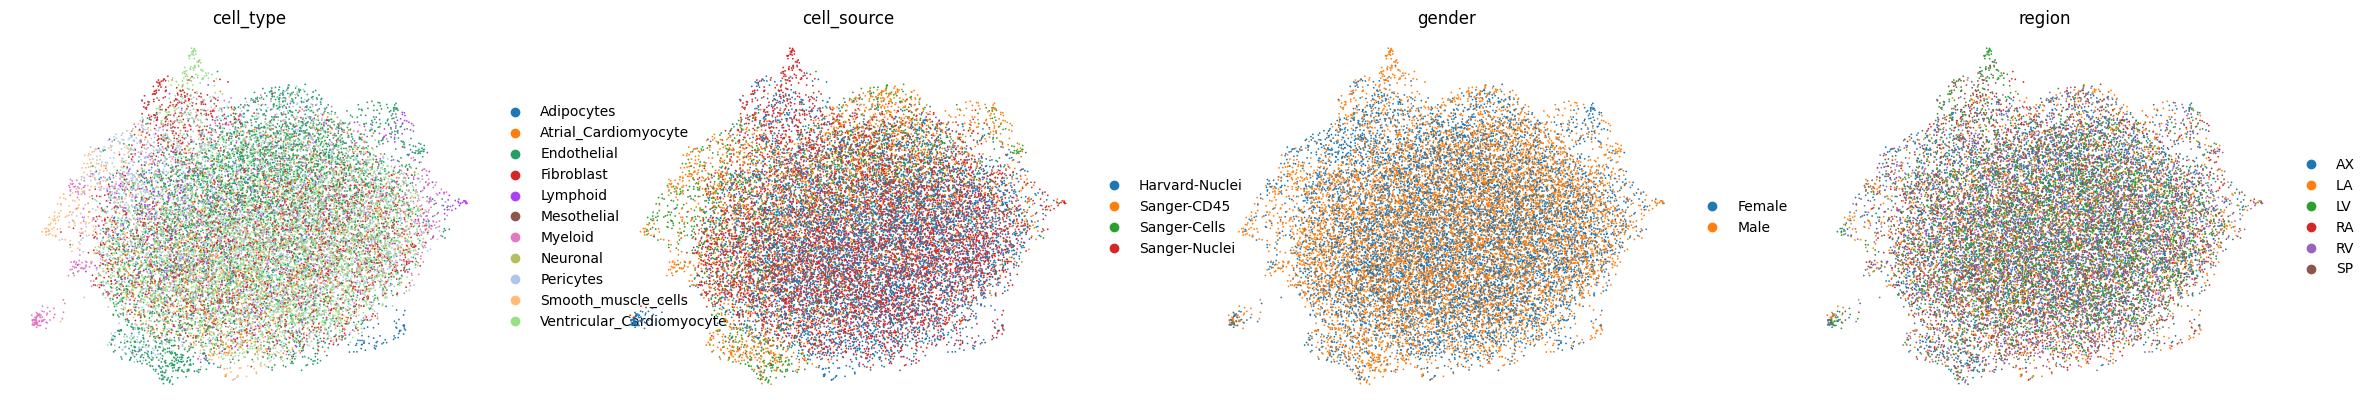

---UMAP for dis2p_Z_1---


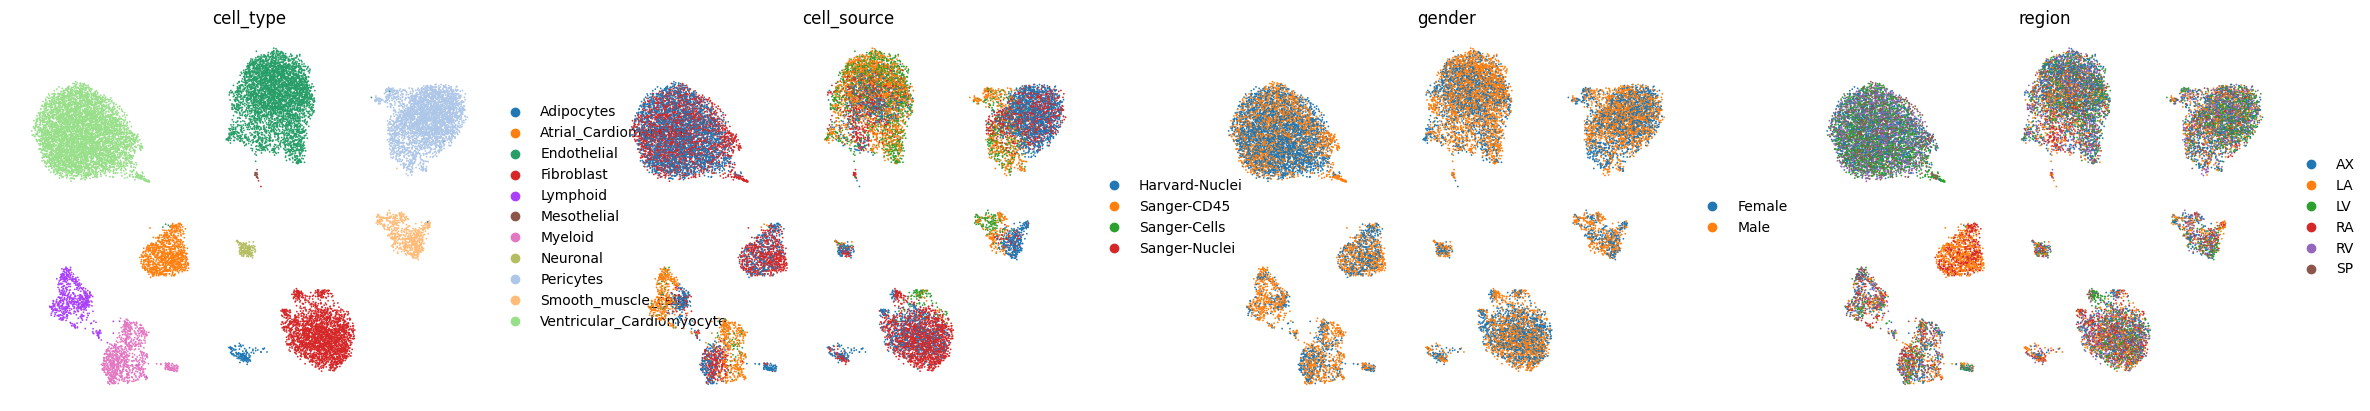

---UMAP for dis2p_Z_2---


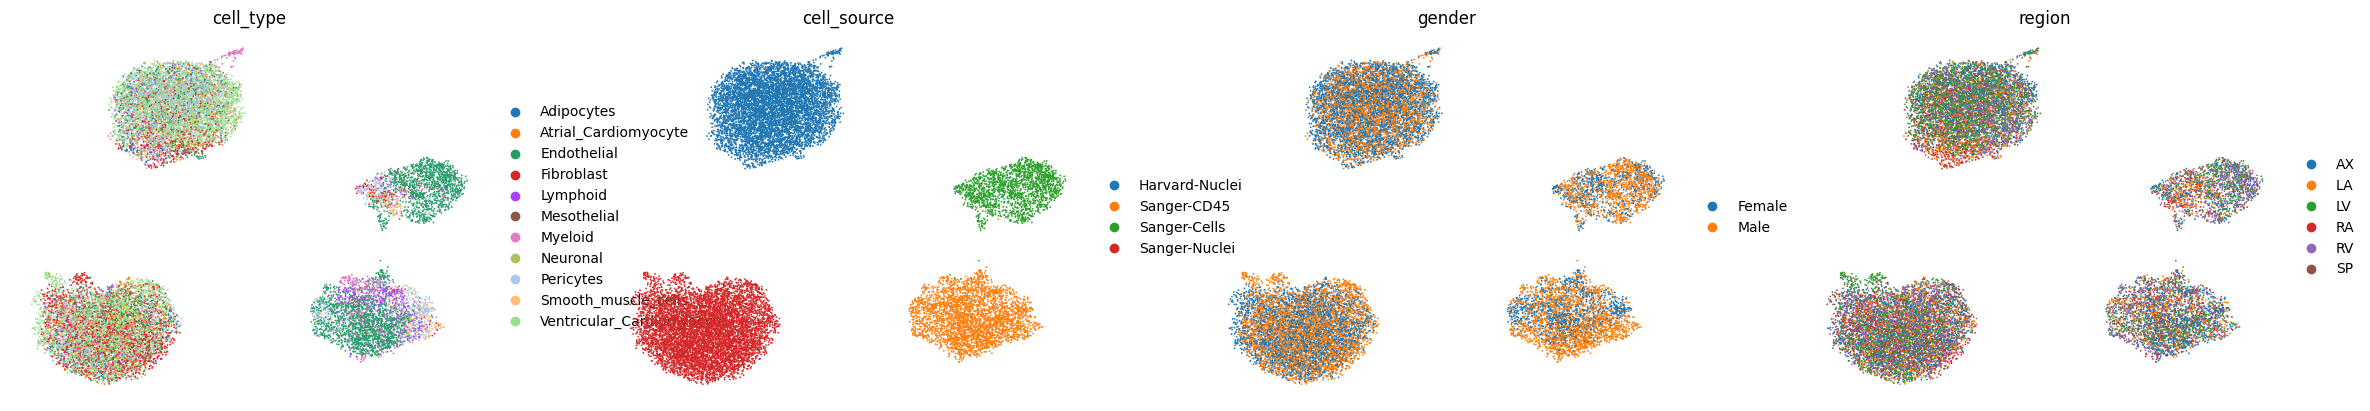

---UMAP for dis2p_Z_3---


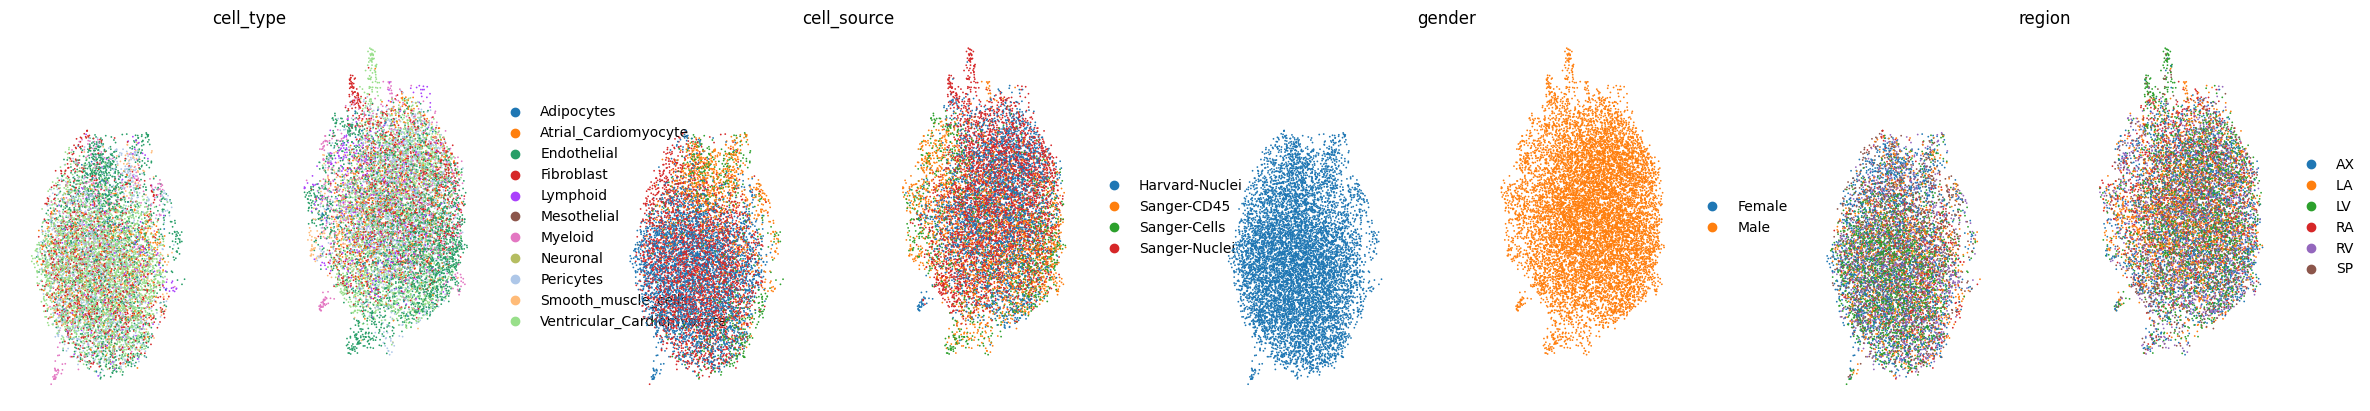

---UMAP for dis2p_Z_4---


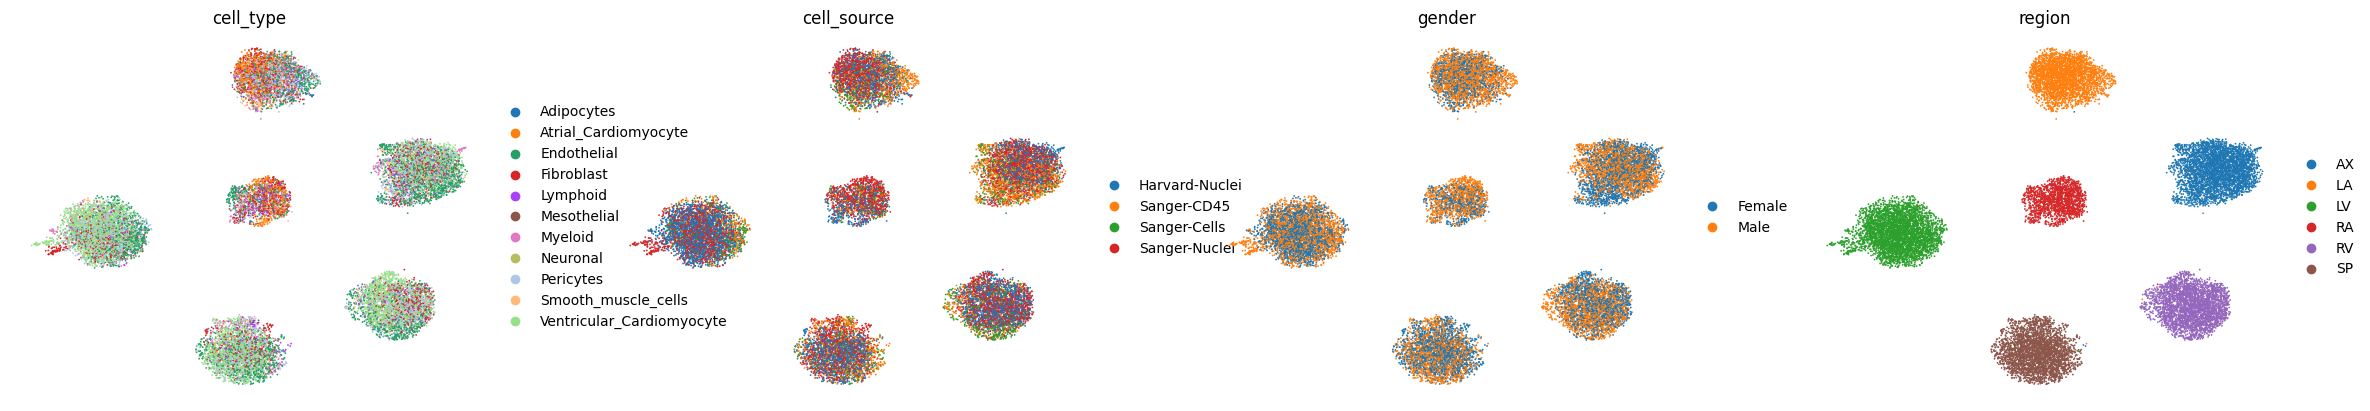

In [22]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )